
This project reference on paper https://machinelearningcoban.com/2017/05/24/collaborativefiltering/ by author Vu Huu Tiep

In [ ]:
%cd /content/drive/MyDrive/Book_recommender
!split -l 275502 /content/drive/MyDrive/Book_recommender/data/df_user_rating.csv split_

/content/drive/MyDrive/Book_recommender


In [ ]:
!nvidia-smi

In [ ]:
!pip install cupy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Book_recommender

/content/drive/MyDrive/Book_recommender


In [2]:
import pandas as pd 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.sparse import csr_matrix
import h5py
import json
import tables 
import torch
from tabulate import tabulate
from numpy.core.multiarray import CLIP
import random
# import cupy as cp

In [4]:
ratings = pd.read_csv('./data/train.csv')
Y_data = ratings.values
ratings2 = pd.read_csv('./data/test.csv')
Y_data_test = ratings2.values

print(Y_data)

[[1 'd06d007d15b9a66fce35dcbc2ff789f0' 5]
 [1 'f14eb7b97b91a036f392e8374ac1ba89' 3]
 [1 'fc0dc60ed86f871c423adeb021552e54' 5]
 ...
 [115077 '0724872b15259aa9eb3dda3ee9eb633a' 2]
 [115077 '86d2aab1da0274574de023be88b58dc1' 3]
 [115078 '75ecc6c7fe308c4cb17fc45ca1a9517e' 4]]


In [5]:

class KNN(object):
    def __init__(self, Y_data,k,dist_func = cosine_similarity,uuCF = 1):
      self.uuCF = uuCF # user-user (1) or item-item (0) CF
      self.Y_data=Y_data
      self.dist_func = dist_func
      self.k = k
      #List of userid
      with open('./data/userid.json', 'r') as f:
          self.userid = json.load(f)
      #List of bookid
      with open('./data/bookid.json','r') as f2:
          self.bookid = json.load(f2)
      #List of mean rate each users
      with open('./data/mean_ratings.json','r') as f3:
          self.mu = json.load(f3)   
      #List of book titles
      with open('./data/book_title.json','r') as f4:
          self.book_title = json.load(f4)   

      #Similarity matrix
      h5file = tables.open_file('./data/similarity_matrix.h5', mode='r')
      self.S = h5file.root.my_array

      #Normalize matrix
      self.Ybar = sparse.load_npz("./data/normalize_sparse_matrix.npz")

      if torch.cuda.is_available():
          self.device = torch.device("cuda")  
          print("Using cuda")       
      else:
          self.device = torch.device("cpu") 
          print("Using cpu")

    def drop_num_users(self):
      mu={}
      for i in range(len(self.Y_data[:])):
        mu[self.Y_data[i,1]]=[]
      for i in range(len(self.Y_data[:])):
        mu[self.Y_data[i,1]].append(i+1)

      num_to_delete = int(len(mu) * 0.84)
      keys_to_delete = random.sample(list(mu.keys()), num_to_delete)
      for key in keys_to_delete:
          del mu[key]

      df = pd.read_csv('./data/df_user_rating.csv')
      df['id'] = df.index + 1
      i=0
      new_list = []
      for key, values in mu.items():
        i+=1
        print(i)
        if i==1:
          print(key)
        for value in values:
          # print(value)
          id_to_copy = value  # Replace with the desired ID value
          selected_rows = df.loc[df['id'] == id_to_copy] 
          new_list.append(selected_rows)
          # print(selected_rows)

      new_df = pd.concat(new_list, ignore_index=True) 
      new_df.to_csv('./data/new_df_user_rating.csv', index=False)

    #This function count each users read how many books
    def count_num_users(self, a):
      mu={}
      for i in range(len(self.Y_data[:])):
        mu[self.Y_data[i,a]]=0
      for i in range(len(self.Y_data[:])):
        mu[self.Y_data[i,a]] +=1
      with open("./data/num_of_rate_per_user.json", "w") as f:
        json.dump(mu, f)
      print(mu)
      return mu

    #Convert userID to their order
    def convert_userID_to_number(self):
      self.userid = self.count_num_users(1)
      for index, keys in enumerate(self.userid):
        self.userid[keys]=index+1
      with open("./data/userid.json", "w") as f:
        json.dump(self.userid, f)

    #Convert bookid to their order
    def convert_bookID_to_number(self):
      self.bookid = self.count_num_users(0)
      for index, keys in enumerate(self.bookid):
        self.bookid[keys]=index+1
      with open("./data/bookid.json", "w") as f:
        json.dump(self.bookid, f)
      

    def normalize_Y(self):
            users = self.Y_data[:, 1] # all users - first col of the Y_data

            self.Ybar_data = self.Y_data.copy()
            self.mu = self.count_num_users(1)
            #Len of user
            self.n_users=len(self.count_num_users(1))
            #Len of book
            self.n_items = len(self.count_num_users(0))
            print(self.n_users)
            print(self.n_items)

            for n in self.mu.keys():
                # row indices of rating done by user n
                # since indices need to be integers, we need to convert
                ids = np.where(users == n)[0].astype(np.int32)
                # indices of all ratings associated with user n
                item_ids = self.Y_data[ids, 0] 
                # and the corresponding ratings 
                ratings = self.Y_data[ids, 2]
                
                # take mean of all rates each user
                m = cp.mean(ratings) 
                if cp.isnan(m):
                    m = 0 # to avoid empty array and nan value
                self.mu[n] = m
                # normalize
                self.Ybar_data[ids, 2] = ratings - self.mu[n]

            file_path = "./data/mean_ratings.json"
            # Save the dictionary as JSON
            with open(file_path, 'w') as json_file:
                json.dump(self.mu, json_file)

            # Save normalize data into a file .npz
            book_array= [self.bookid[str(self.Y_data[i, 0])] for i in range(len(self.Y_data))]
            user_array =  [self.userid[self.Y_data[i, 1]] for i in range(len(self.Y_data))] 
            data = self.Ybar_data[:, 2].astype(np.float32)

            self.Ybar = sparse.coo_matrix( (data, (book_array, user_array)), ( self.n_items+1,self.n_users+1) )
            self.Ybar = self.Ybar.tocsr()
            sparse.save_npz("./data/normalize_sparse_matrix.npz", self.Ybar)

    def similarity(self):
        #Load normalize data
        self.Ybar=sparse.load_npz("./data/normalize_sparse_matrix.npz")
        #calculate cosine similarity
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)
        # save similarity matrix into hdf5 file
        h5file = tables.open_file('./data/similarity_matrix.h5', mode='w')
        my_array = h5file.create_array('/', 'my_array', np.zeros((38732, 38732), dtype=np.float32))
        my_array[:] = self.S
        h5file.close()
   
    def pred_by_torch(self, u, i, normalized = 1):
        if u not in self.userid:
          return 10
        if str(i) not in self.bookid:
          return 11
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        i=int(i)
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 0] == i)[0].astype(np.int32)
        # Step 2: 
        users_rated_i = self.Y_data[ids, 1]
        users_rated_i_copy = self.Y_data[ids, 1]

        for index,user in enumerate(users_rated_i):
            users_rated_i[index]=self.userid[str(user)]
        # Step 3: find similarity btw the current user and others 
        # who already rated i
        sim = [self.S[self.userid[u], int(index)] for index in users_rated_i]
        sim = torch.tensor(sim).to(self.device)
        # Step 4: find the k most similarity users
        a = torch.argsort(sim)[-self.k:] 

        # and the corresponding similarity levels
        nearest_s = [sim[id] for id in a]
        nearest_s = torch.tensor(nearest_s).to(self.device)
        # How did each of 'near' users rated item i
        r = self.Ybar[self.bookid[str(i)], users_rated_i[a.to("cpu")]]
        if isinstance(r, np.float32):
          r = torch.tensor(r).unsqueeze(0).to(self.device)

        else:
          r = torch.tensor(r.toarray()[0]).to(self.device)

        self.max_sim = torch.max(nearest_s)

        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (torch.matmul(r, nearest_s)/(torch.abs(nearest_s).sum() + 1e-8)  )
            # torch.matmul(r, nearest_s)/(torch.abs(nearest_s).sum() + 1e-8) + self.mu[u]   
        return (torch.matmul(r, nearest_s)/(torch.abs(nearest_s).sum() + 1e-8) + self.mu[u] )


    def recommend(self, u):
        """
        Determine all items should be recommended for user u.
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 1] == u)[0]
        items_rated_by_u = self.Y_data[ids, 0].tolist()     
        
        recommended_items = {}

        for i in self.bookid.keys():
            if int(i) not in items_rated_by_u:
                rating = self.pred_by_torch(u, i)
                if i not in self.book_title.keys():
                  continue
                book_title = self.book_title[i]
                recommended_items[book_title] = rating

        recommended_items = dict(sorted(recommended_items.items(), key=lambda item: item[1]))
        return recommended_items 

    # def print_recommendation(self):
    #     """
    #     print all items which should be recommended for each user 
    #     """    
    #     print('Recommendation: ')
    #     for u in self.userid.keys():
    #         recommended_items = self.recommend(u)
    #         if self.uuCF:
    #             print('    Recommend item(s):', [key for key,value in recommended_items.items()], 'for user', u) 
    #         else: 
    #             print('    Recommend item', u, 'for user(s) : ', [key for key,value in recommended_items.items()]) 
      
    def print_recommendation_for_1_user(self, userr):
        recommended_items = self.recommend(userr)

        data = [[title, rating] for title, rating in recommended_items.items()]
        #Only pick top 10 highest rating items
        data = data[-10:]
        #Print result by table
        table = tabulate(data[::-1], headers=["Title", "Rating"], tablefmt="grid")
        print("Top recomended books for user: ", userr)
        print(table)
    

# 251063 users
# 47767 books
# 251064 A.shape[0]

In [6]:
from collections import Counter
import time
rs = KNN(Y_data,k = 20, uuCF = 1)

       
# rs.drop_num_users()
# rs.count_num_users(1)
# rs.convert_userID_to_number()
# rs.convert_bookID_to_number()
# rs.normalize_Y()

# rs.similarity()
# rs.print_recommendation()

start_time = time.time()
rs.print_recommendation_for_1_user('f14eb7b97b91a036f392e8374ac1ba89')
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")
# print(rs.pred_by_torch(Y_data_test[0, 1], Y_data_test[0, 0]))

#158.6137375831604 seconds
# 1f9406656d36289f20af226656aa5467 05094dcfaac099025c7ddb4cdd2be942
# so sach ng dung  4 11
#140ad053658a0fc0aefc965958

Using cuda
Top recomended books for user:  f14eb7b97b91a036f392e8374ac1ba89
+----------------------------------------------------+----------+
| Title                                              |   Rating |
+====================================================+==========+
| Heart of Darkness                                  |  4.44747 |
+----------------------------------------------------+----------+
| Forgiven (Firstborn, #2)                           |  4.29508 |
+----------------------------------------------------+----------+
| Scarlett                                           |  4.21428 |
+----------------------------------------------------+----------+
| Under the Jaguar Sun                               |  4.07692 |
+----------------------------------------------------+----------+
| Spark of Life: A Novel of Resistance               |  4.07141 |
+----------------------------------------------------+----------+
| The Road Back                                      |  4.07141 |


In [ ]:

 # squared error
# user = '9c1182dd8bef1b68def5be5d4aa7615d'
result = []
index=0
SE_all = 0
n_tests_all = 0
for user in rs.userid.keys():
  print("===========================================================================================")
  print(index)
  user = '9e665c34dcec47ce49a844e0f5f18ed8'
  index+=1
  SE = 0
  n_tests = 0
  ids = np.where(Y_data[:,1]==user)[0]
  book_list = {}
  for i in ids:
    # print("user: ", Y_data[i,1], "book: ", Y_data[i,0],"rate: ", Y_data[i,2])
    book_list[Y_data[i,0]] = Y_data[i,2]
  print(book_list)
  
  for key in book_list.keys():
    pred = rs.pred_by_torch(user, int(key))
    if(pred==10 or pred==11):
        SE +=0
        # n_tests-=1
        continue
    real_pred = pred+ rs.mu[user]
    # print("pred: ", real_pred, "user: ",user,"ITEMS: ",key)
    # if int(key) in list(book_list.keys()):
    SE += (real_pred - book_list[int(key)])**2 
    n_tests +=1
    print(real_pred, book_list[int(key)] , key)
    SE_all += (real_pred - book_list[int(key)])**2 
    n_tests_all += 1

  print("number of book: ", n_tests)
  SE=SE.cpu().detach().numpy()
  RMSE = np.sqrt(SE/n_tests)
  print ('User:',user,' RMSE =', RMSE)
  a = [user , n_tests , RMSE]
  result.append(a)
  break
SE_all = SE_all.cpu().detach().numpy()
RMSE_all = np.sqrt(SE_all/n_tests_all)

print("Total user: ", n_tests_all,"RMSE for ALL: ",RMSE_all)
# np.savez('/content/drive/MyDrive/Book_recommender/data/RMSE.npz', RMSE=result)

#b778cfe3a3c4cff1ee47daba9e5cd068 | 4 books | RMSE = 0.70956611411556
#d06d007d15b9a66fce35dcbc2ff789f0 | 40 books | RMSE = 0.20953903035874452
#83318ab6e690d305e3db5c7f55cd085d | 198 books | RMSE = 0.21677380160553825
#41ff989d2a2f4f3b3188ffcf1e01c853 | 104 books | RMSE = 0.14738476379778973
#9c1182dd8bef1b68def5be5d4aa7615d | 361 books | RMSE = 0.15505900338737735
#RMSE for ALL:  0.22684756463086178
#9e665c34dcec47ce49a844e0f5f18ed8 11, 4443, 10890

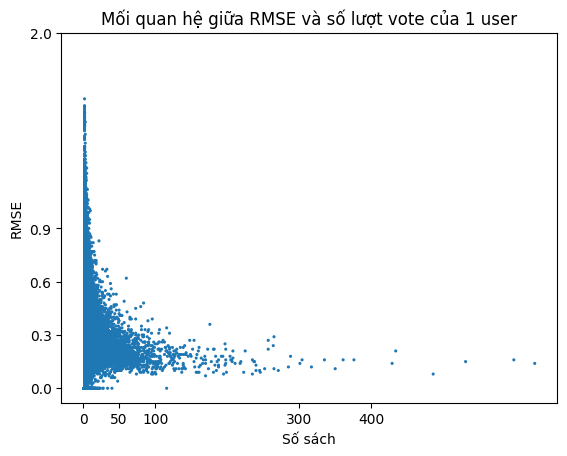

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu sai số RMSE và số sách

data = np.load('/content/drive/MyDrive/Book_recommender/data/RMSE.npz')
RMSE = data['RMSE']
# RMSE_all = 0 
# num_books_all = 0
# for i in range(len(RMSE)):
#   num_books_all += int(RMSE[i,1])
#   RMSE_all += (float(RMSE[i,2])**2)*int(RMSE[i,1])
# print(num_books_all, RMSE_all)
# print("RMSE in train: ", np.sqrt(RMSE_all/num_books_all))

rmse_values = [round(float(i),2) for i in RMSE[:,2]] 
book_counts = [int(i) for i in RMSE[:,1]]

# # Vẽ đồ thị phân phối
plt.scatter(book_counts, rmse_values, marker='o', edgecolors='none',s=5)
plt.xlabel('Số sách')
plt.ylabel('RMSE')
plt.title('Mối quan hệ giữa RMSE và số lượt vote của 1 user')
plt.xticks([0, 50, 100, 300, 400])  # Chỉ hiển thị chỉ mục 20, 30, 40 trên trục x
plt.yticks([0, 0.3, 0.6 , 0.9, 2])
plt.show()

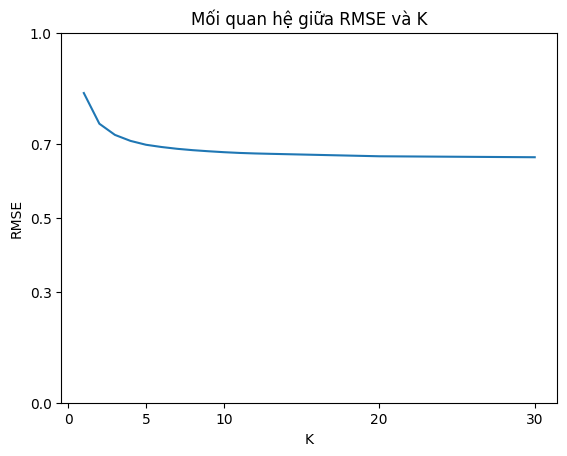

In [ ]:
import matplotlib.pyplot as plt
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 30]
RMSE = [0.8379124578021907, 0.7548497969980845, 0.7246680708175783, 0.708454702495985, 0.6979383177215303, 0.6918534045463841, 0.6870230942738922, 0.6833247880307853,
0.6804218057280662, 0.6778697673838585, 0.675865728343715, 0.6744570368737138, 0.6734268699987428, 0.6667962165002679, 0.6641957144442437]

# # Vẽ đồ thị phân phối
plt.plot(K, RMSE)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('Mối quan hệ giữa RMSE và K')
plt.xticks([0, 5, 10, 20, 30])  # Chỉ hiển thị chỉ mục 20, 30, 40 trên trục x
plt.yticks([0, 0.3, 0.5 , 0.7, 1])
plt.show()

In [ ]:
#Evaluate on test set

max_sim = []
error = []
total_greater_zero2 = []
n_tests = Y_data_test.shape[0]
n_tests_copy = n_tests
SE = 0 # squared error
# print("n_test",n_tests)
zero_truth = 0
zero_sim = 0
for n in range(n_tests):
    pred = rs.pred_by_torch(Y_data_test[n, 1], Y_data_test[n, 0])
    if(pred==10 or pred==11):
      SE +=0
      n_tests_copy-=1
      continue
    # if(Y_data_test[n, 2] == 0):
    #   zero_truth+=1
    #   continue
    if(rs.max_sim.item()  < 0.2):
      # print("2:",rs.max_sim)
      zero_sim +=1
      continue
    real_pred = pred+ rs.mu[Y_data_test[n, 1]]
    # print("===================================================================================================")
    max_sim.append(rs.max_sim)
    error.append(Y_data_test[n, 2]-real_pred)
    # print("pred: ", real_pred,"truth: ",Y_data_test[n, 2],"user: ",Y_data_test[n, 1],"ITEMS: ",Y_data_test[n, 0])
    # print("===================================================================================================")


    SE += (real_pred - Y_data_test[n, 2])**2 
print(n_tests_copy)

SE=SE.cpu().detach().numpy()
RMSE = np.sqrt(SE/n_tests_copy)
print ('User-user CF, RMSE =', RMSE)

#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 30]
#[0.8379124578021907, 0.7548497969980845, 0.7246680708175783, 0.708454702495985, 0.6979383177215303, 0.6918534045463841, 0.6870230942738922, 0.6833247880307853]
#[0.6804218057280662, 0.6778697673838585, 0.675865728343715, 0.6744570368737138, 0.6734268699987428, 0.6667962165002679, 0.6641957144442437]

#                    ,0, 0.05, 0.1, 0.2
#1.1712862967846929 , 1.0248328419504409, 0.8480161257361198, 0.6869495970535759, 0.4550243448482623

0
23035
User-user CF, RMSE = 0.4942254134340325


2.45332932472229
3.256882429122925
2.811157464981079
2.348918914794922
4.157142639160156
2.921998977661133
2.1666667461395264
2.769063949584961
2.4350836277008057
2.0907719135284424
2.0924415588378906
2.8752779960632324
3.9067344665527344
2.412947654724121
2.6869869232177734
2.1875803470611572
2.88181734085083
3.073242664337158
2.011448860168457
3.361961603164673
2.3096113204956055
2.770225763320923
2.390066146850586
3.5480904579162598
2.8459970951080322
2.512040138244629
3.0076208114624023
2.938075304031372
3.4237685203552246
2.8976516723632812
2.5408709049224854
2.608400821685791
2.439401626586914
2.064957618713379
2.352051258087158
3.047149181365967
2.4694833755493164
3.7758874893188477
2.5378777980804443
2.7338714599609375
3.2003211975097656
2.2661514282226562
2.3956189155578613
2.2214760780334473
3.084350109100342
3.8746094703674316
3.1860504150390625
2.3483800888061523
2.508244276046753
3.0675392150878906
3.766836166381836
3.399634838104248
2.2118496894836426
2.5352447032928467
2

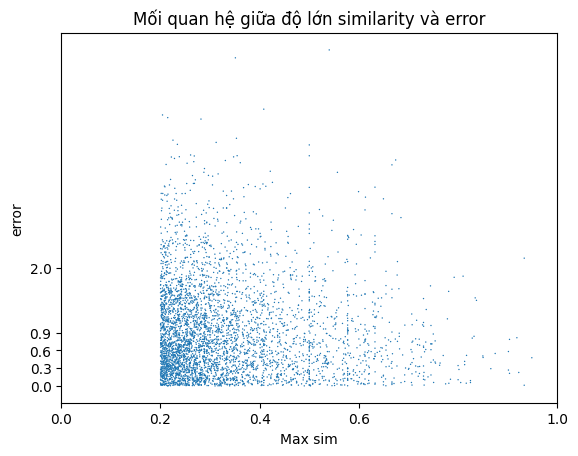

In [ ]:
# print(max_sim)
import matplotlib.pyplot as plt
max_sim2 = [max_sim[i].item() for i in range(len(max_sim))]
error2 = [abs(error[i].item()) for i in range(len(error))]

for i in error2:
  if i>2:
    print(i)
plt.scatter(max_sim2, error2, marker='o', edgecolors='none',s=1)
plt.xlabel('Max sim')
plt.ylabel('error')
plt.title('Mối quan hệ giữa độ lớn similarity và error')
plt.xticks([0, 0.2, 0.4, 0.6, 1])  # Chỉ hiển thị chỉ mục 20, 30, 40 trên trục x
plt.yticks([0, 0.3, 0.6 , 0.9, 2])
plt.show()

In [ ]:
#SPlit into test and train set
#Loc output_file.csv ra 1 file test
import pandas as pd
import random

# Đường dẫn tới file input
input_file_path = '/content/drive/MyDrive/Book_recommender/data/output_file.csv'

# Đường dẫn tới file output
output_file_path = '/content/drive/MyDrive/Book_recommender/data/test.csv'

output_file_path2 = '/content/drive/MyDrive/Book_recommender/data/train.csv'
# Số lượng dòng muốn lấy ngẫu nhiên
num_rows = 30000

df = pd.read_csv(input_file_path)
random_indices = random.sample(range(len(df)), num_rows)
sorted_arr = sorted(random_indices)
print(sorted_arr)
random_rows = df.iloc[random_indices]
df = df.drop(random_indices)
# Ghi các dòng đã lấy vào file output
random_rows.to_csv(output_file_path, index=False)
df.to_csv(output_file_path2, index=False)

[27, 47, 48, 55, 56, 74, 86, 87, 105, 116, 121, 127, 137, 158, 174, 177, 180, 188, 201, 211, 218, 219, 243, 245, 247, 252, 255, 265, 267, 284, 297, 305, 308, 316, 318, 335, 338, 345, 356, 373, 386, 403, 419, 421, 424, 438, 441, 451, 454, 462, 470, 471, 485, 489, 494, 500, 505, 509, 515, 523, 537, 538, 569, 573, 577, 586, 594, 598, 600, 603, 609, 618, 628, 630, 639, 648, 650, 654, 657, 667, 669, 677, 684, 690, 764, 765, 767, 770, 789, 797, 803, 808, 819, 822, 832, 840, 849, 855, 885, 892, 899, 900, 922, 954, 962, 981, 983, 995, 1009, 1010, 1015, 1017, 1029, 1049, 1064, 1083, 1113, 1120, 1121, 1131, 1154, 1156, 1164, 1174, 1179, 1182, 1194, 1197, 1204, 1205, 1219, 1224, 1237, 1241, 1252, 1276, 1286, 1289, 1301, 1304, 1306, 1321, 1323, 1329, 1334, 1336, 1360, 1368, 1370, 1371, 1372, 1391, 1392, 1400, 1413, 1418, 1420, 1421, 1440, 1458, 1462, 1465, 1473, 1474, 1493, 1504, 1520, 1521, 1529, 1534, 1537, 1551, 1555, 1585, 1588, 1590, 1593, 1609, 1610, 1632, 1633, 1644, 1656, 1662, 1688, 1693,